In [52]:
import numpy as np
import matplotlib.pyplot as plt 

from PIL import Image


In [80]:
#x = np.load('/media/mccdual2080/Almacenamiengto/SahirProjects/SahirReyes/dataSetAutoencoder/DatasetAutoencoder/DataSetLatentSpace/Npy/Balanced/V1/Dataset120x360GreysNewCategories.npy')
x = np.load("/media/mccdual2080/Almacenamiengto/SahirProjects/SahirReyes/dataSetAutoencoder/DatasetAutoencoder/DataSetLatentSpace/Npy/Dataset120x360Greys.npy")
x = x*255
print(x.shape)
print("x min: ", x.min())
print("x max: ", x.max())
print("x dtype: ", x.dtype)

carpeta = 'V1W10'
data = np.load('Resultados/ResultadoCompletoOldCategories/'+carpeta+'/ResultadosEstimacionDecodificacionSinCategorico.npy')
print(data.shape)

window = 10
rows = 120
cols = 360
channels = 1

(1254, 120, 360)
x min:  0.0
x max:  255.0
x dtype:  float32
(374, 4, 120, 360, 1)


<Figure size 2000x2000 with 0 Axes>

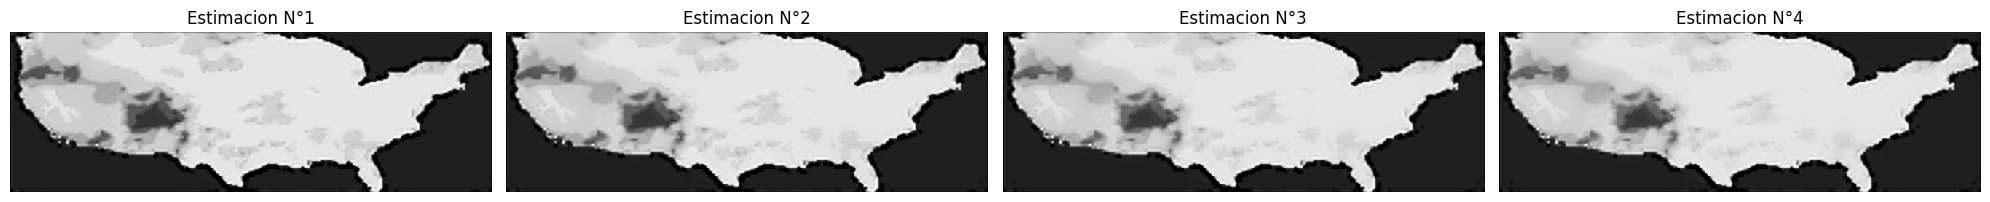

In [81]:

fig = plt.figure(figsize=(20,20))
r = 3
c = 4
ac = 1
pos = 100
horizon = 4

fig = plt.figure(figsize=(20,20))
for i in range(horizon):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(data[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Estimacion N°{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()

In [82]:
def create_shifted_frames_2(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, data.shape[1]-1, :, :]
    return x, y

def agroup_window(data, window):
    new_data = [data[i:window+i] for i in range(len(data)-window+1)]
    return np.array(new_data)



def reduce_data(data, window):
    # Calcula la cantidad deseada de elementos en el resultado final, igual al número de ventanas
    desired_length = len(data) - window + 1
    
    # Calcula el intervalo de selección para mantener el mismo número de elementos que el resultado de la agrupación en ventanas
    if desired_length > 1:
        step = len(data) // desired_length
    else:
        step = 1  # Evita la división por cero si desired_length es 1
    
    # Selecciona elementos de data a intervalos regulares
    reduced_data = data[::step]
    
    # Asegúrate de que el resultado final tenga la misma cantidad de elementos que el resultado de la agrupación en ventanas
    if len(reduced_data) > desired_length:
        reduced_data = reduced_data[:desired_length]
    
    return reduced_data

    #Crea cubos con su propia información de tamaño h
def get_cubes(data, h):
    new_data = []
    for i in range(0, len(data)-h):
        new_data.append(data[i:i+h])
    new_data = np.array(new_data)
    print(new_data.shape)
    return new_data

#Toma todos los colores existentes en la imagen
def get_colors(image):
  aux = []
  band = True
  for i in image:
    for j in i:

      for k in aux:
        if j.tolist() == k:
          band = False
          break
      if band:
        aux.append(j.tolist())
      band = True
  return np.array(aux)

def recolor_greys_image(data, palette):
    rows, cols = len(data), len(data[0])
    aux = np.zeros((rows, cols), dtype=np.uint64)
    for i in range(rows):
        for j in range(cols):
            aux[i,j] = min(palette, key= lambda x:abs(x-data[i,j]))
    return aux

def get_colors_optimized(image):
    # Aplanar la imagen a una lista de píxeles (forma: número de píxeles, canales)
    pixels = image.reshape(-1, image.shape[-1])
    
    # Utilizar np.unique para encontrar filas únicas (colores únicos) en los píxeles aplanados
    # axis=0 opera a lo largo del eje de las filas para encontrar filas únicas
    # return_counts=False para no retornar los conteos de cada color único
    unique_colors = np.unique(pixels, axis=0, return_counts=False)
    
    return unique_colors

#Función para dada una paleta solo tomar los colores de esa paleta en la imagen
def quantizetopalette(silf, palette, dither=False, mode="P"):
  """Convert an RGB or L mode image to use a given P image's palette."""
  silf.load()
  palette.load()
  im = silf.im.convert(mode, 0, palette.im)
  # the 0 above means turn OFF dithering making solid colors
  return silf._new(im)

def gray_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('L', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img, 'L')
  newImage = quantizetopalette(oldImage,palImage, mode="L")
  res_image = np.asarray(newImage)
  return res_image

def gray_quantized_optimized(img, palette):
    # Asegurar que img es un array de NumPy
    img = np.array(img, dtype=np.uint8)
    
    # Crear una imagen PIL directamente desde el array de NumPy
    oldImage = Image.fromarray(img, 'L')
    
    # Convertir la imagen a modo 'P' utilizando la paleta proporcionada
    # Nota: La paleta debe ser ajustada al formato esperado por PIL si es necesario.
    newImage = oldImage.quantize(palette=Image.fromarray(palette, 'P'))
    
    # Convertir la imagen cuantizada de vuelta a un array de NumPy
    res_image = np.asarray(newImage)
    
    return res_image

In [56]:
x_3 = reduce_data(x, window)
print(x_3.shape)

(1245, 120, 360)


In [83]:
x_2 = agroup_window(x, window)
print(x_2.shape)
x_train = x_2[:int(len(x_2)*.7)]
x_test = x_2[int(len(x_2)*.7):]
x_validation = x_train[int(len(x_train)*.8):]
x_train = x_train[:int(len(x_train)*.8)]
x_train = x_train.reshape(len(x_train), window, rows, cols, channels)
x_validation = x_validation.reshape(len(x_validation), window, rows, cols, channels)
x_test = x_test.reshape(len(x_test), window, rows, cols, channels)

print("Forma de datos de entrenamiento: {}".format(x_train.shape))
print("Forma de datos de validación: {}".format(x_validation.shape))
print("Forma de datos de pruebas: {}".format(x_test.shape))

x_train, y_train = create_shifted_frames_2(x_train)
x_validation, y_validation = create_shifted_frames_2(x_validation)
x_test, y_test = create_shifted_frames_2(x_test)

print("Training dataset shapes: {}, {}".format(x_train.shape, y_train.shape))
print("Validation dataset shapes: {}, {}".format(x_validation.shape, y_validation.shape))
print("Test dataset shapes: {}, {}".format(x_test.shape, y_test.shape))

#x_test, y_test = create_shifted_frames_2(x_test)

(1245, 10, 120, 360)
Forma de datos de entrenamiento: (696, 10, 120, 360, 1)
Forma de datos de validación: (175, 10, 120, 360, 1)
Forma de datos de pruebas: (374, 10, 120, 360, 1)
Training dataset shapes: (696, 9, 120, 360, 1), (696, 120, 360, 1)
Validation dataset shapes: (175, 9, 120, 360, 1), (175, 120, 360, 1)
Test dataset shapes: (374, 9, 120, 360, 1), (374, 120, 360, 1)


In [84]:
classes = np.array([0, 255, 220, 177, 119, 70, 35]) # 255, 220, 177, 119, 70, 35  0
classesBalanced = np.array([18, 54, 90, 126, 162, 198, 234])
rows = 120
cols= 360
print(rows)
print(cols)
h = 4

120
360


In [85]:
print("merged_data" ,data.shape)
print("x_test",x_test.shape)
print("y_test",y_test.shape)
 
y_test = get_cubes(y_test, h)

merged_data (374, 4, 120, 360, 1)
x_test (374, 9, 120, 360, 1)
y_test (374, 120, 360, 1)
(370, 4, 120, 360, 1)


In [86]:
colors = get_colors_optimized(x_test[-10,0])
print("COLORSS", colors)
print("COLORS", colors.shape)

colorss = get_colors_optimized(data[-10,0])
print("COLORSS", colorss)
print("COLORS", colorss.shape)

COLORSS [[  0.]
 [ 35.]
 [ 70.]
 [119.]
 [177.]
 [220.]
 [255.]]
COLORS (7, 1)
COLORSS [[6.38401970e-11]
 [1.52916430e-10]
 [1.19004084e-09]
 ...
 [9.84694779e-01]
 [9.84882176e-01]
 [9.90275502e-01]]
COLORS (41994, 1)


In [87]:
naive = x_test[:-4]
data = data[1:-3]

In [88]:
        
#new_data = data[:, -h:]
new_data = data
#n_real = naive[:, -h:]*255
n_real = naive[:, -h:]

        
naive = naive[:, -h:]

In [89]:
print("min naive", naive.min())
print("max naive", naive.max())
print("min data", new_data.min())
print("max data", new_data.max())
print("min n_real", n_real.min())
print("max n_real", n_real.max())
#n_real = n_real/255

min naive 0.0
max naive 255.0
min data 2.3622496645413216e-13
max data 0.9924324750900269
min n_real 0.0
max n_real 255.0


In [90]:
print("XX")
print("Y    ",y_test.shape)
print('new  ',new_data.shape)
print('naive',n_real.shape)

print(min(new_data[0,0,60]))
print(max(new_data[0,0,60]))

XX
Y     (370, 4, 120, 360, 1)
new   (370, 4, 120, 360, 1)
naive (370, 4, 120, 360, 1)
[0.00092751]
[0.95082504]


In [91]:
new_data = new_data * 255
new_data = new_data.astype(np.uint8)

In [92]:
print("new_data", new_data.shape)
print(colorss.shape)
print(min(new_data[0,0,60]))
print(max(new_data[0,0,60]))
colors1s = get_colors_optimized(new_data[-10,0])
print("COLORSS", colors1s)
print("COLORS", colors1s.shape)

new_data (370, 4, 120, 360, 1)
(41994, 1)
[0]
[242]
COLORSS [[  0]
 [  1]
 [  2]
 [  3]
 [  4]
 [  5]
 [  6]
 [  7]
 [  8]
 [  9]
 [ 10]
 [ 11]
 [ 12]
 [ 13]
 [ 14]
 [ 15]
 [ 16]
 [ 17]
 [ 18]
 [ 19]
 [ 20]
 [ 21]
 [ 22]
 [ 23]
 [ 24]
 [ 25]
 [ 26]
 [ 27]
 [ 28]
 [ 29]
 [ 30]
 [ 31]
 [ 32]
 [ 33]
 [ 34]
 [ 35]
 [ 36]
 [ 37]
 [ 38]
 [ 39]
 [ 40]
 [ 41]
 [ 42]
 [ 43]
 [ 44]
 [ 45]
 [ 46]
 [ 47]
 [ 48]
 [ 49]
 [ 50]
 [ 51]
 [ 52]
 [ 53]
 [ 54]
 [ 55]
 [ 56]
 [ 57]
 [ 58]
 [ 59]
 [ 60]
 [ 61]
 [ 62]
 [ 63]
 [ 64]
 [ 65]
 [ 66]
 [ 67]
 [ 68]
 [ 69]
 [ 70]
 [ 71]
 [ 72]
 [ 73]
 [ 74]
 [ 75]
 [ 76]
 [ 77]
 [ 78]
 [ 79]
 [ 80]
 [ 81]
 [ 82]
 [ 83]
 [ 84]
 [ 85]
 [ 86]
 [ 87]
 [ 88]
 [ 89]
 [ 90]
 [ 91]
 [ 92]
 [ 93]
 [ 94]
 [ 95]
 [ 96]
 [ 97]
 [ 98]
 [ 99]
 [100]
 [101]
 [102]
 [103]
 [104]
 [105]
 [106]
 [107]
 [108]
 [109]
 [110]
 [111]
 [112]
 [113]
 [114]
 [115]
 [116]
 [117]
 [118]
 [119]
 [120]
 [121]
 [122]
 [123]
 [124]
 [125]
 [126]
 [127]
 [128]
 [129]
 [130]
 [131]
 [132]
 [133]
 [

In [93]:
new_data = new_data.reshape(new_data.shape[:-1])
print("HoY", new_data.shape)

HoY (370, 4, 120, 360)


In [94]:
aux = []
for i in new_data:
    aux2 = []
    for j in i:
        #res = cv2.cvtColor(j, cv2.COLOR_GRAY2RGB)
        #res = recolor_greys_image(j, classes)
        #rgb_quantized(res, classes_rgb)
        #res = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)
        res = gray_quantized_optimized(j, classes)
        res = recolor_greys_image(res, classes)
        aux2.append(res)
    aux.append(np.array(aux2))

In [95]:

new_data = np.array(aux)
print("SHAPEE", new_data.shape)
color_data = get_colors(new_data[-10,0])
print("DCOLORS", color_data)
new_data = new_data.reshape(new_data.shape[0],new_data.shape[1],new_data.shape[2],new_data.shape[3],1)

SHAPEE (370, 4, 120, 360)
DCOLORS [  0  70  35 119 177 220 255]


In [96]:
#y_test = y_test * 255
#naive = naive * 255

print("YCOLORS", get_colors(y_test[-10,0]))
print("NCOLORS", get_colors(naive[-10,0]))
print("DCOLORS", get_colors(new_data[-10,0]))

print("XS")
print(f"new data shape {new_data.shape}")
print(f"y_test.shape {y_test.shape}")
print(f"new data shape {naive.shape}")

l_clas = len(classes)

YCOLORS [[  0.]
 [255.]
 [177.]
 [119.]
 [ 70.]
 [220.]
 [ 35.]]
NCOLORS [[  0.]
 [255.]
 [177.]
 [ 70.]
 [220.]
 [119.]
 [ 35.]]
DCOLORS [[  0]
 [ 70]
 [ 35]
 [119]
 [177]
 [220]
 [255]]
XS
new data shape (370, 4, 120, 360, 1)
y_test.shape (370, 4, 120, 360, 1)
new data shape (370, 4, 120, 360, 1)


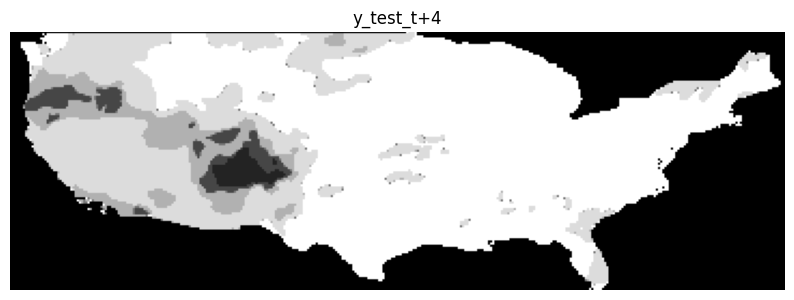

In [97]:

fig = plt.figure(figsize=(10,10))
r = 3
c = 4
ac = 1
pos = 100
for i in range(h):
    #fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(y_test[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('y_test_t+{}'.format(i+1))
    plt.savefig("Resultados/ResultadoCompletoOldCategories/"+carpeta+"/y_test_t+{}.jpg".format(i+1))
#plt.savefig("Resultados/ResultadoCompleto/"+carpeta+"/y_test.jpg")
plt.show()



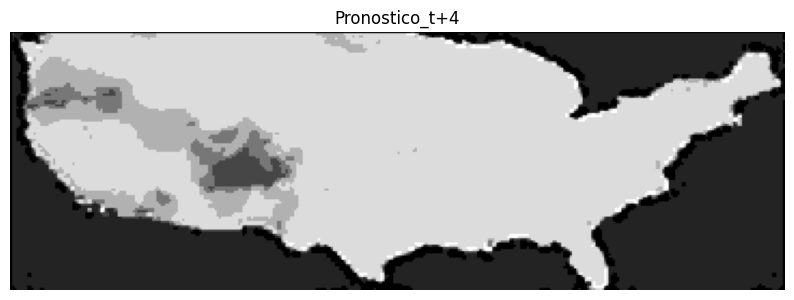

In [98]:
fig = plt.figure(figsize=(10,10))
r = 3
c = 4
ac = 1
pos = 100
for i in range(h):
    #fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(new_data[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Pronostico_t+{}'.format(i+1))
    plt.savefig("Resultados/ResultadoCompletoOldCategories/"+carpeta+"/Pronostico_t+{}.jpg".format(i+1))
plt.show()

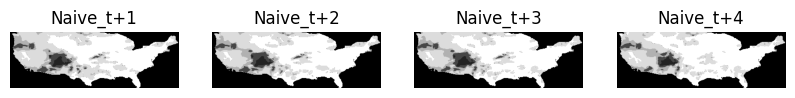

In [99]:

fig = plt.figure(figsize=(10,10))
r = 3
c = 4
ac = 1
pos = 100
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(naive[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Naive_t+{}'.format(i+1))
    plt.savefig("Resultados/ResultadoCompletoOldCategories/"+carpeta+"/Naive_t+{}.jpg".format(i+1))
plt.show()

In [100]:
#print 
print (f"lengeth x_test: {y_test.shape[0]}")
print (f"h: {h}")
print (f"rows: {rows}")
print (f"cols: {cols}")
#rows = 120
#cols = 360

lengeth x_test: 370
h: 4
rows: 120
cols: 360


In [101]:
cm_f = np.zeros((l_clas, l_clas), dtype=np.uint64)
cm_n = np.zeros((l_clas, l_clas), dtype=np.uint64)
print(cm_f)

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [102]:
print("range rows" , range(rows))
print("range cols" , range(cols))

range rows range(0, 120)
range cols range(0, 360)


In [103]:
for e in range(y_test.shape[0]):
    for k in range(h):
        for i in range(rows):
            
            for j in range(cols):
                #print(f"e: {e}, k: {k}, i: {i}, j: {j}")
                
                pos1 = np.where(classes == y_test[e, k, i, j])[0][0]
                pos2 = np.where(classes == new_data[e, k, i, j])[0][0]
                pos3 = np.where(classes == naive[e, k, i, j])[0][0]
                cm_f[pos1, pos2] += 1
                cm_n[pos1, pos3] += 1

print("Matriz de confusión de pronóstico")
print(cm_f)
print("Matriz de confusión de naive")
print(cm_n)

Matriz de confusión de pronóstico
[[ 3574355     1376    34530   112683   182418   386942 20419284]
 [    2826   411510 18979803   183507    26494     1431     1447]
 [    2197    36928 10274750  2197452    53359     6548      644]
 [     319     3541   340692  2983272   335430    56490     2072]
 [      82     1169    85772   101745   147507    19005     1370]
 [     223       87     7119   169251   802184  1135634    13429]
 [      22        9      406     4227    24216   478932   331311]]
Matriz de confusión de naive
[[24711560        0        0        0        0        4       24]
 [       0 16960311  2472388   114668    55290     3970      391]
 [       0  2547638  9038390   838343    54297    85998     7212]
 [      20    86642   907679  2292237    66085   335547    33606]
 [       8    48570    56809    73353   125204    46190     6516]
 [       0     1070    82362   368238    49896  1491452   134909]
 [       0      216     2688    15119     4278   157591   659231]]


In [104]:
import pandas as pd
# Convert cm_f numpy array to pandas DataFrame
df_cm_f = pd.DataFrame(cm_f)

print(df_cm_f)

df_cm_n = pd.DataFrame(cm_n)

print(df_cm_n)

# Crear el DataFrame de la primera matriz de confusión como antes
df_cm_f = pd.DataFrame(cm_f, index=[f'True_{i}' for i in range(len(cm_f))],
                       columns=[f'Pred_{i}' for i in range(len(cm_f[0]))])

# Crear el DataFrame de la segunda matriz de confusión como antes
df_cm_n = pd.DataFrame(cm_n, index=[f'True_{i}' for i in range(len(cm_n))],
                       columns=[f'Pred_{i}' for i in range(len(cm_n[0]))])

# Calcular el desplazamiento necesario para la segunda matriz (longitud de la primera matriz + 2 por la columna vacía)
offset = df_cm_f.shape[1] + 2

# Crear un escritor de Excel
with pd.ExcelWriter("Resultados/ResultadoCompletoOldCategories/"+carpeta+"/combined_confusion_matrices.xlsx") as writer:
    # Escribir la primera matriz en la hoja de cálculo empezando en la primera columna
    df_cm_f.to_excel(writer, startcol=0, index=True)
    
    # Escribir la segunda matriz en la hoja de cálculo con un desplazamiento
    df_cm_n.to_excel(writer, startcol=offset, index=True)

#with pd.ExcelWriter("DroughtDatasetMask/NPY61_180"+parte+"/cm_f_n.xlsx") as writer:
#    df_cm_f.to_excel(writer, sheet_name='cm_f')
#    df_cm_n.to_excel(writer, sheet_name='cm_n')


         0       1         2        3       4        5         6
0  3574355    1376     34530   112683  182418   386942  20419284
1     2826  411510  18979803   183507   26494     1431      1447
2     2197   36928  10274750  2197452   53359     6548       644
3      319    3541    340692  2983272  335430    56490      2072
4       82    1169     85772   101745  147507    19005      1370
5      223      87      7119   169251  802184  1135634     13429
6       22       9       406     4227   24216   478932    331311
          0         1        2        3       4        5       6
0  24711560         0        0        0       0        4      24
1         0  16960311  2472388   114668   55290     3970     391
2         0   2547638  9038390   838343   54297    85998    7212
3        20     86642   907679  2292237   66085   335547   33606
4         8     48570    56809    73353  125204    46190    6516
5         0      1070    82362   368238   49896  1491452  134909
6         0       216    

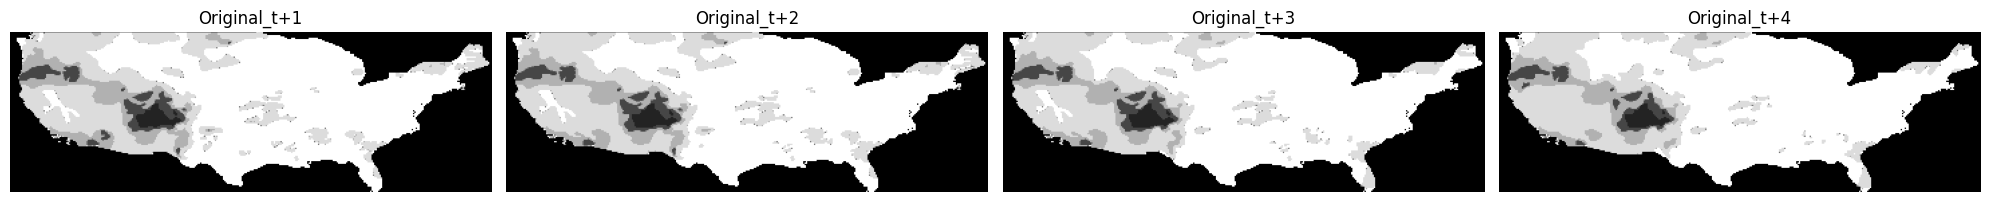

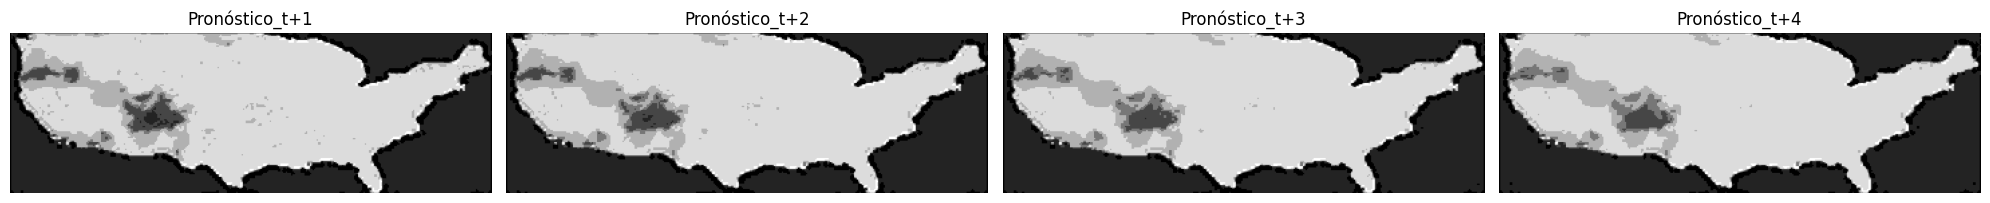

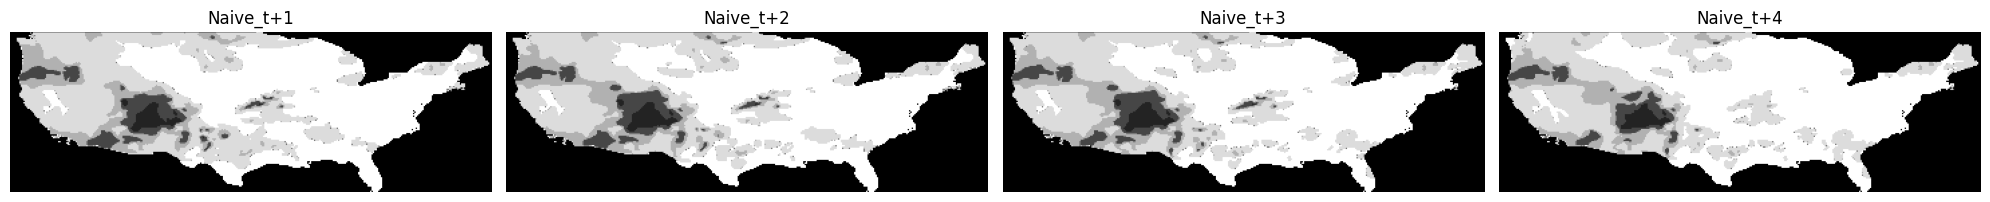

In [105]:
fig = plt.figure(figsize=(20,20))
r = 3
c = 4
ac = 1
pos = 100

for i in range(h):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(y_test[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Original_t+{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()
fig = plt.figure(figsize=(20,20))
for i in range(h):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(new_data[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Pronóstico_t+{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()
fig = plt.figure(figsize=(20,20))

for i in range(h):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(naive[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Naive_t+{}'.format(i+1))
    ac += 1

# Ajustar el espaciado entre subplots
plt.subplots_adjust(wspace=.1, hspace=0.05)  # Puedes disminuir estos valores si es necesario
plt.tight_layout()
plt.show()